In [22]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools

## About the data
he example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:
|Field name|Description|
|---|---|
ID|Clump Thickness|
Clump|Clump Thickness|
UnifSize|Uniformity of cell size|
UnifShape|Uniformity of cell shape|
MargAdh|Marginal adhesion|
SingEpiSize|Single epithelial cell size|
BareNuc|Bare nuclei|
BlandChorm|Bland chromatin|
NormNucl|Normal Nuclei|
Mit|Mitoses|
Class|Benign or malignant|


In [2]:
# Download data
!wget -O cell_samples.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv

--2025-11-14 14:21:50--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19975 (20K) [text/csv]
Saving to: 'cell_samples.csv'

cell_samples.csv    100%[===================>]  19.51K  --.-KB/s    in 0.06s   

2025-11-14 14:21:52 (317 KB/s) - 'cell_samples.csv' saved [19975/19975]



In [3]:
# Load Data From CSV File¶
df = pd.read_csv('cell_samples.csv')
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

In [4]:
cell_df = df

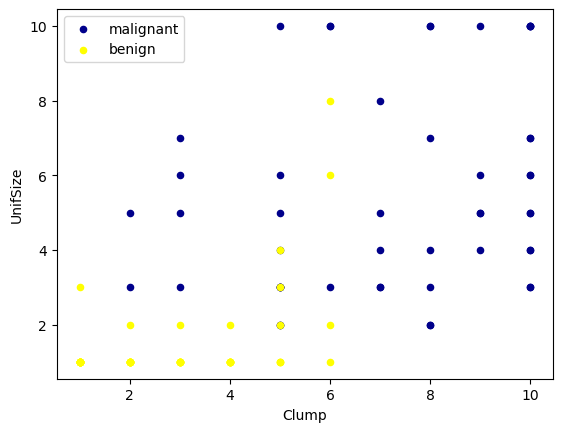

In [5]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class']== 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax)
plt.show()

## Data pre-processing and selection¶
Columns data types:

In [6]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

BareNuc column includes some values that are not numerical. We can drop those rows:

In [7]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

/var/folders/7m/y8yqbwcj4_s9pbq64p2cdkw00000gn/T/ipykernel_4276/1178285181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')


ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [8]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)).

In [9]:
y = np.asarray(cell_df['Class'])
y[0:5]

array([2, 2, 2, 2, 2])

### Train/Test dataset
We split our dataset into train and test set:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print('Train Set:', X_train.shape, y_train.shape)
print('Test Set:', X_test.shape, y_test.shape)

Train Set: (546, 9) (546,)
Test Set: (137, 9) (137,)


## Modeling (SVM with Scikit-learn)
The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:
1. Linear
2. Polynomial
3. Radial basis function (RBF)
4. Sigmoid
   
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. 

In [11]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


After being fitted, the model can then be used to predict new values:

In [12]:
yhat = clf.predict(X_test)
yhat[0:5]

array([2, 4, 2, 4, 2])

## Evaluation¶

In [18]:
def plot_confusion_matric(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('onfusion matrix, without normalization')
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tickmarks = np.arange(len(classes))
    plt.xticks(tickmarks, classes, rotation=45)
    plt.yticks(tickmarks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else "black")
        
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

onfusion matrix, without normalization
[[85  5]
 [ 0 47]]


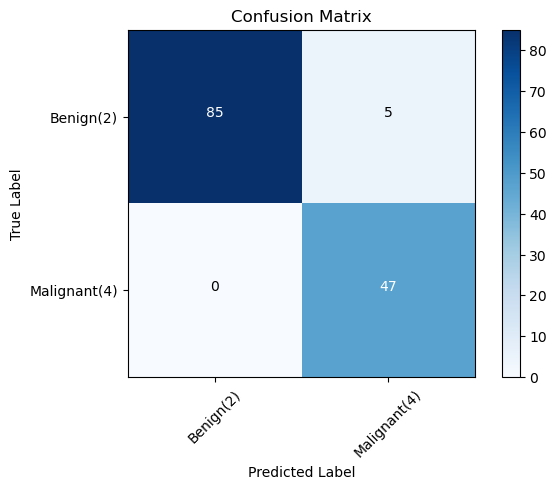

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2, 4])
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matric(cnf_matrix, classes=['Benign(2)','Malignant(4)'], normalize=False, title='Confusion Matrix')

Use the f1_score from sklearn library:

In [21]:
f1_score(y_test, yhat, average='weighted')

0.9639038982104676

The jaccard index for accuracy:

In [23]:
jaccard_score(y_test, yhat, pos_label=2)

0.9444444444444444